In [1]:
# Importing the necessary libraries
import torch
from torch import optim, utils, tensor, nn

import matplotlib.pyplot as plt
from getdist import plots, MCSamples

from Network import Generator, Discriminator
from Signal_Generator import *

from tqdm import tqdm

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Defining the hyperparameters
datasize = 16000
num_sources = 1
noise_amplitude = 0

num_latent_variables = 20
learning_rate = 1e-5
weight_clip = 0.1

d_loss_threshold = -0.1
g_loss_threshold = -0.3
threshold_adjustment = 0.025
max_steps = 300

num_epochs = 1000

z = torch.randn(1, num_latent_variables, 1).to(device)

In [21]:
# Defining the distribution for amplitude and angular frequency
def amp_distribution(size):
    """
    Amplitude distribution using uniform distribution.
    """
    return np.random.uniform(6, 14, size=size)

def omega_distribution(size):
    """
    Angular frequency distribution using uniform distribution.
    """
    return np.random.uniform(0.33, 0.67, size=size)

In [3]:
# Creating the dataset
dataset = []

for i in range(datasize):
    SG = Signal_Generator(num_sources=1, noise_amplitude=0)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
# Defining the WGAN traning class
class WGAN(nn.Module):
    def __init__(self, num_latent_variables, lr, weight_clip):
        super(WGAN, self).__init__()
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

100%|██████████| 1000/1000 [2:09:18<00:00,  7.76s/it] 


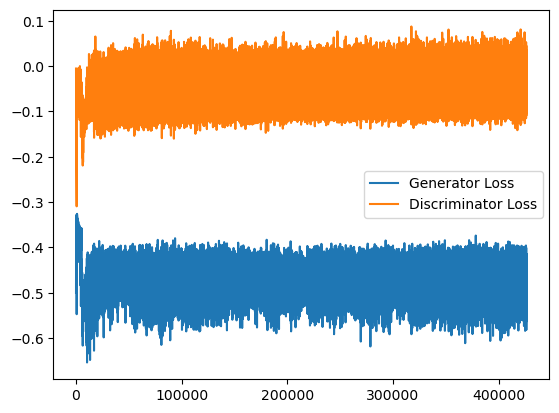

In [5]:
# Adaptive training
wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.1).to(device)

loss_list = []

ncri_list = []
ngen_list = []

training_d = True

for epoch in tqdm(range(num_epochs)):
    ncri = 0
    ngen = 0
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        #z = torch.randn(1, num_latent_variables, 1).to(device)

        critic_steps = 0
        generator_steps = 0
        
        while training_d and critic_steps < max_steps:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ncri+=1
            critic_steps+=1
            if loss[0] > g_loss_threshold:
                training_d = False
                break

        if critic_steps == max_steps:
            g_loss_threshold -= threshold_adjustment

        while not training_d and generator_steps < max_steps:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ngen+=1
            generator_steps+=1
            if loss[1] > d_loss_threshold:
                training_d = True
                break

        if generator_steps == max_steps:
            d_loss_threshold -= threshold_adjustment

    ncri_list.append(ncri)
    ngen_list.append(ngen)

    #print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {loss[0]}, Discriminator loss: {loss[1]}")

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.legend()

In [6]:
for i in range(20):
    loss = wgan.train_generator(signal_tensor, params_tensor, z)
    loss_list.append(loss)

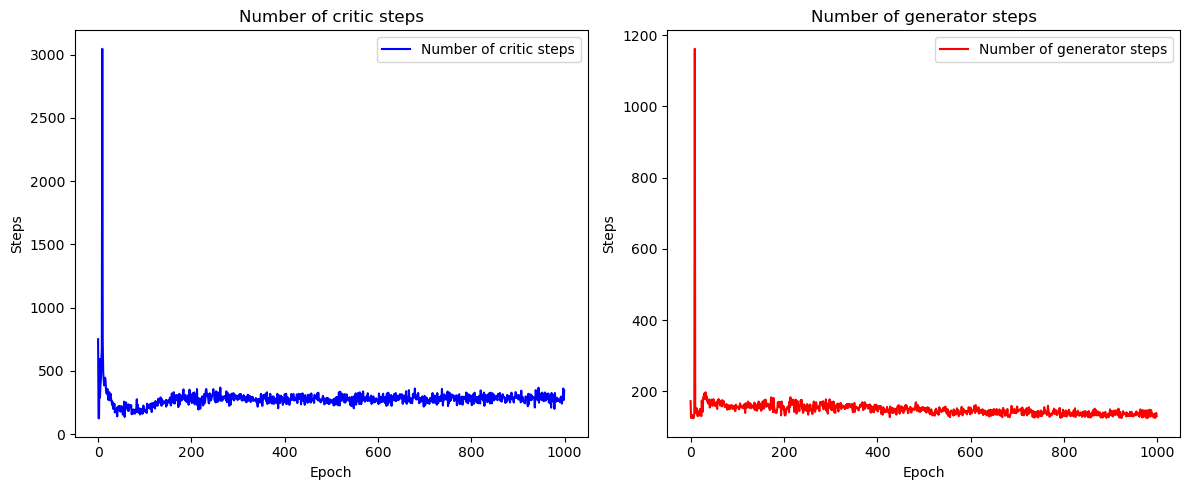

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(ncri_list, label='Number of critic steps', color='blue')
axs[0].set_title('Number of critic steps')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Steps')
axs[0].legend()

axs[1].plot(ngen_list, label='Number of generator steps', color='red')
axs[1].set_title('Number of generator steps')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Steps')
axs[1].legend()

plt.tight_layout()

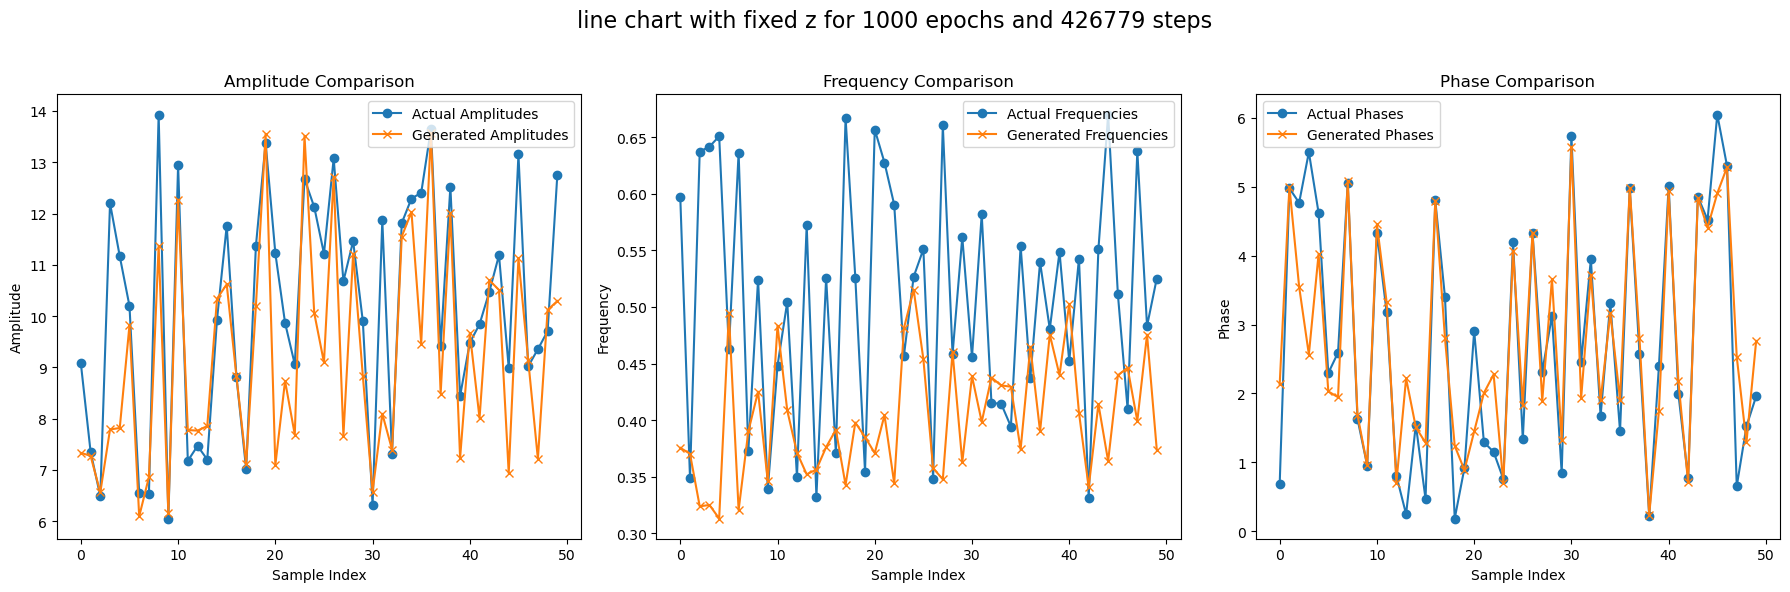

In [25]:
generator = wgan.generator
generator.eval()

params_list = []
generated_params_list = []

test_times = 50
for i in range(test_times):
    TS = Signal_Generator(num_sources=1, noise_amplitude=0, amp_distribution_func=amp_distribution, omega_distribution_func=omega_distribution)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        #z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    #print(params)
    #print(generated_params)

actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.suptitle(f'line chart with fixed z for {num_epochs} epochs and {len(loss_list)} steps', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()